*First compiled: June 19, 2017. Updated Mar 28, 2018.*

# PAGA for minimal examples

The notebook serves as a basic introduction into partition-based graph abstraction (PAGA), describing the primary steps that you'd typically perform when applying it to your data along with the conceptual ramifications of what may be provided on input.
* Section 1: [Simulated data for myeloid progenitor development](#data1)  
* Section 2: [Simulated data for different degrees of clustering](#data2)

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/krumsiek11_blobs.h5ad'

scanpy==1.0+1.g701aaec anndata==0.5.8 numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


## Section 1: Simulated data for myeloid progenitor development <a id="data1"></a>

The simulated data that we'll use here describes development from a progenitor cell to four differentiated cell types: monocyte, erythrocyte, megakaryocyte and neutrophil, and only uses the expression levels of a few curated marker genes. See [Krumsiek *et al.* (2009)](https://doi.org/10.1371/journal.pone.0022649) for the definition of the boolean literature-curated network underlying the simulation and discussion of marker genes. The data has been generated using `sc.tl.sim('krumsiek11')`; see [here](https://github.com/theislab/scanpy_usage/tree/master/170430_krumsiek11) for more details. We know the ground truth, which is hard to establish for real data.

To add disconnected structure to the continuous differentiation manifold, which is almost always present in real data,  we add a "noise" clusters from a Gaussian mixture model. In real data this might be due to imperfect sampling or just a very heterogeneous tissue. The clusters are disconnected in the sense that they are not part of the differentiation  trajectories. One of the strengths of PAGA is that it is able to identify them as not being part of the ground truth trajectory and leave them out of the proposed structure.

We begin by importing our data, and then add the extra "noise" clusters to it (hence the name `krumsiek11_blobs` that will show up from now on). When working on your own data, prepare the count matrix with genes as the columns and cells as the rows, with their names in the first row/column respectively, and import them using `sc.read()`. You can also call `adata.transpose()` if your files follow a different convention. The parser is robust, and can handle files with commas, tabs or spaces as delimiters. After importing the count matrix, you can add cell annotations to the resulting structure, the information for which you can prepare in an external file with the first column as cell names. You can take a look at [nestorowa16](https://github.com/theislab/graph_abstraction/blob/master/nestorowa16/nestorowa16.ipynb) for exact syntax and a download of some appropriately formatted input files. Scanpy can also directly use Cell Ranger count matrices on input, see [the Seurat-like tutorial](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb) for details.

The actual data provided on input can be either raw counts or log-transformed counts. The count matrix will require some basic preprocessing prior to commencing the analysis, with raw count data processed, for instance, with a simple call of `sc.pp.recipe_zheng17()`. See the Seurat tutorial for many more options preprocessing.

In [2]:
adata_krumsiek11 = sc.datasets.krumsiek11()
adata_krumsiek11.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [3]:
adata_blobs = sc.datasets.blobs(cluster_std=0.5, n_centers=2)
adata_blobs.var_names = adata_krumsiek11.var_names
adata = adata_krumsiek11.concatenate(adata_blobs, index_unique='-')
adata.uns = adata_krumsiek11.uns
adata.write(results_file)

Since we know the underlying ground truth, we can visualize the simulated data as heatmaps. The darker the heatmap the higher the expression. This is not immediately applicable to experimental data you are likely to have on input, but a heatmap of the trajectories we infer created later on in the notebook may be of more relevance.

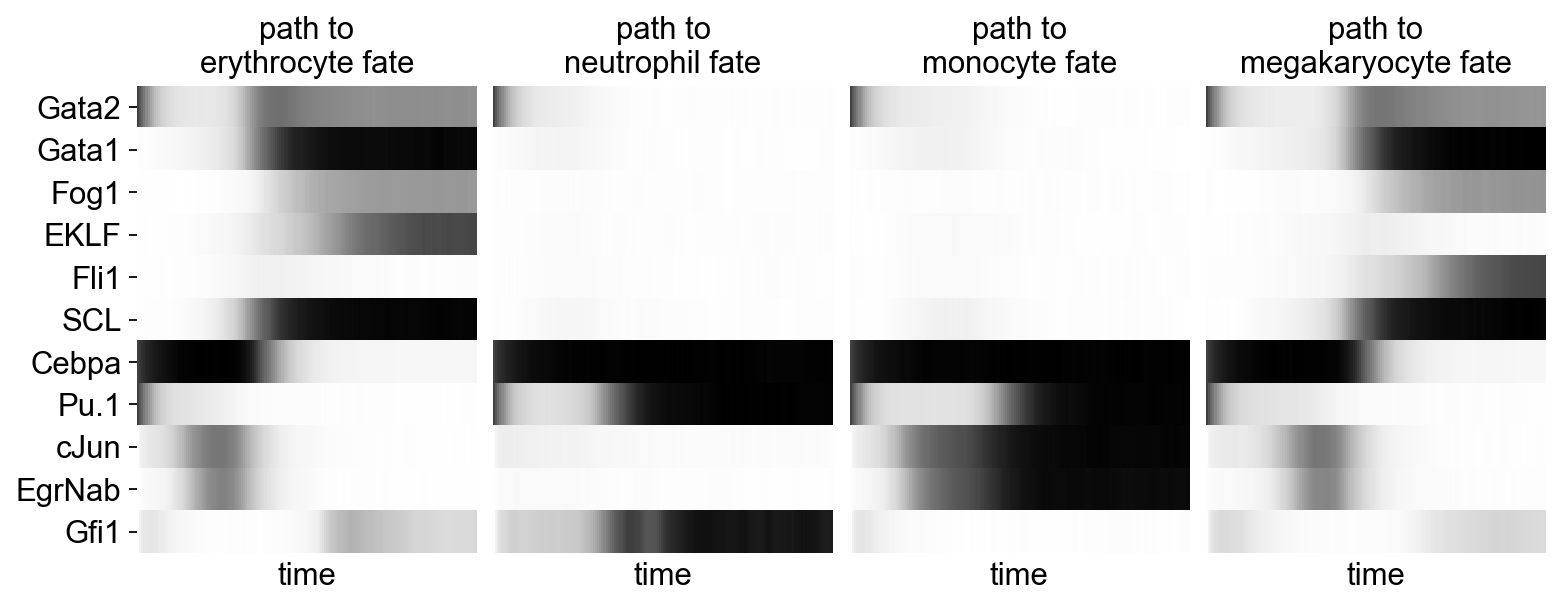

In [4]:
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.1})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ititle, (title, idcs) in enumerate(
    [('erythrocyte', (160, 320)), ('neutrophil', (480, 640)), 
     ('monocyte', (0, 160)), ('megakaryocyte', (320, 480)), ]):
    pl.sca(axs[ititle])
    img = pl.imshow(adata.X[idcs[0]:idcs[1]].T, aspect='auto', interpolation='nearest', cmap='Greys')
    if ititle == 0: pl.yticks(range(adata.n_vars), adata.var_names)
    else: pl.yticks([])
    pl.title('path to\n{} fate'.format(title))
    pl.xticks([])
    pl.grid(False)
    pl.xlabel('time')
    axs[ititle].set_frame_on(False)
pl.savefig('./figures/krumsiek11_timeseries_heatmap.png', dpi=300)    
pl.show()

### Visualization

Now that we have our data, we can visualise it. PAGA's preferred visualisation is the Fruchterman & Reingold algorithm (obtained via `sc.tl.draw_graph()` below), but Scanpy has many other options for visualizing the data. We precompute the visualisations to begin with, and then add this extra information to our constantly expanding `.h5ad` result archive (that's the `sc.read()` and `sc.write()` calls bookending the code blocks - storing our analysis results for easy later access every step of the way).

In [5]:
sc.pp.neighbors(adata, n_neighbors=30)  # generate a neighborhood graph of single cells
sc.tl.draw_graph(adata, random_state=5)  # draw this graph using standard drawing algorithms

computing neighbors
    using data matrix X directly
    finished (0:00:03.1) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fr"
    finished (0:00:12.2) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obs)


Now that the visualisations are precomputed, we can produce and save the corresponding plots. It should be noted that PAGA saves its output files in predetermined default locations, you can append to the standard naming schemes if you change `save=True` to whatever you want to append to the name. So, for example, if you wanted the tSNE plot to be `figures/tsne1.png` instead of the default `figures/tsne.png`, you'd call the tSNE plotter function with `save='1'`. You can change the default directory by changing `sc.settings.figdir` to any string that should be prepended to your path. You can also save the figures by right-clicking in your firefox or other browser and selecting "Save Image As".

... storing 'blobs' as categorical
... storing 'cell_type' as categorical
saving figure to file ./figures/draw_graph_fr.png


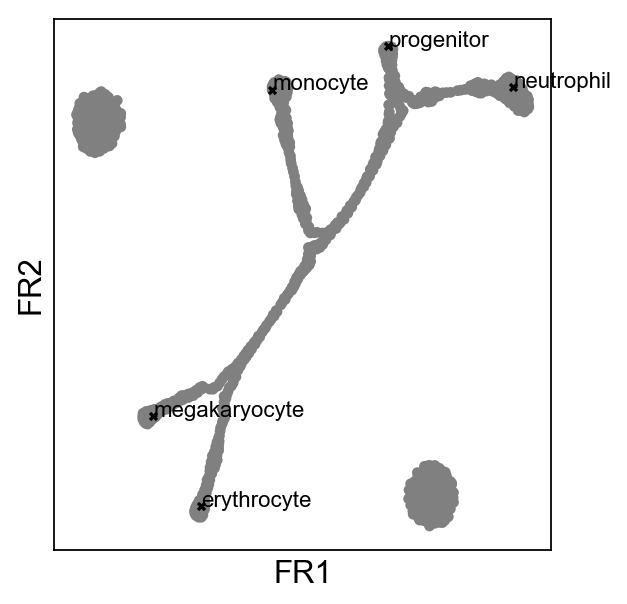

In [6]:
sc.pl.draw_graph(adata, save=True)

In [7]:
adata.write(results_file)

## Construct the abstracted graph

PAGA's follows proceeds in two steps: cluster the single-cell graph and then construct the abstracted graph based on the connectivity between the clusters. The resolution parameter controls how coarse the clustering is - the higher the value, the more clusters you'll get and the smaller they'll be. It's not a bad idea to run the following few bits of code with a couple of different resolutions, trying to find a visually convincing parititon.

In [8]:
adata = sc.read(results_file)

In [9]:
sc.tl.louvain(adata, resolution=2.5)
sc.tl.paga(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.3) --> found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:00.0) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


There are a number of different ways to visualise the resulting abstracted graph, with the most power going to the layout parameter of the function call. The default is the Fruchterman & Reingold algorithm PAGAin (`layout='fr'`), with the most common alternative being Reingold-Tilford (`layout='rt'`), which creates a hierarchical structure based on where you specify the tree's roots to be.

In the present case, the result is tree-like, so we use Reingold-Tilford. Seeing how clustering results may vary slightly between machines, ensure that the `root` parameter in the call below is pointed at the cluster that has the progenitor cells in it, plus two clusters representative of the noise blobs! If you don't provide a root parameter value but ask for the `'rt'` layout, Scanpy will make an educated guess for you based on the graph topology.

In [10]:
adata

AnnData object with n_obs × n_vars = 1280 × 11 
    obs: 'batch', 'blobs', 'cell_type', 'louvain'
    uns: 'draw_graph', 'highlights', 'iroot', 'neighbors', 'louvain', 'paga', 'louvain_sizes'
    obsm: 'X_draw_graph_fr'

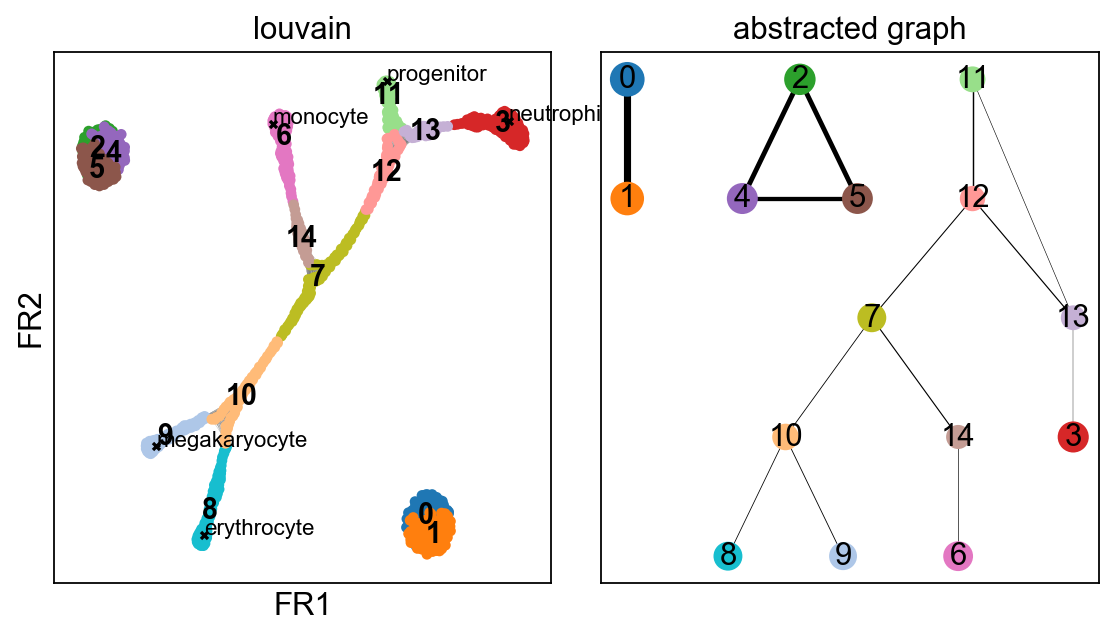

In [11]:
sc.pl.paga_compare(adata, basis='X_draw_graph_fr', root=[11, 2, 0], layout='rt')

Now that we've computed all of this, we can save it PAGA in and export for external reusage, if so desired.

In [12]:
adata.write(results_file)
adata.write_csvs(results_file[:-5])

### Gene changes along paths - "pseudotime series"

You can also plot the distance along the manifold (pseudotime) - an extension of DPT [Haghverdi *et al.* (2016)](https://doi.org/10.1038/nmeth.3971). To do this, you need to ensure that your object has information on the position of the root stored within it before calling the Louvain clustering, as previously mentioned. Otherwise, the clustering won't know where to anchor the pseudotime and will make no attempt to compute it. You don't necessarily have to pick this value out by hand though, for example [nestorowa16](https://github.com/theislab/graph_abstraction/blob/master/nestorowa16/nestorowa16.ipynb) uses the cell type annotation that was imported along with the data to set the root to the index of the first cell tagged as Stem:

    adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_types'] == 'Stem')[0]

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.         1.         0.9994561  0.9990158  0.9974686  0.99713373
     0.99360853 0.9897025  0.98377657 0.98280567]
    finished (0:00:00.1) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


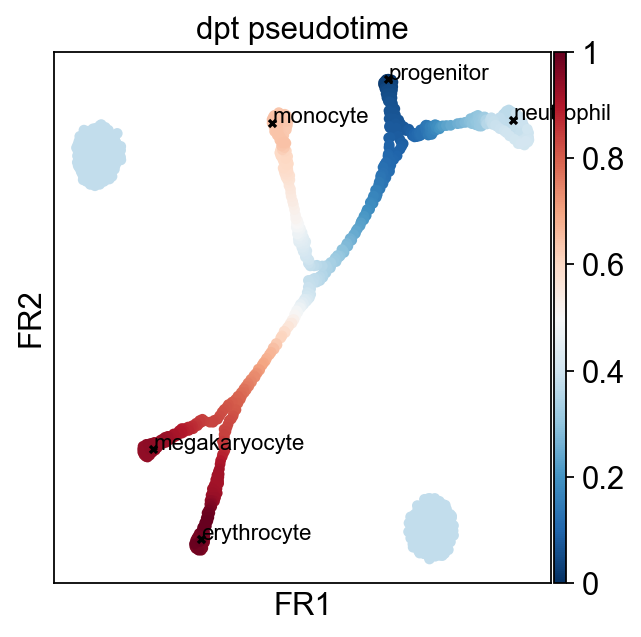

In [13]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color='dpt_pseudotime')

Now that we've inferred the abstracted graph and a pseudotime, we can visualise the gene expression changes along proposed paths. Notice how when specifying the `paths`, we start at the progenitor root (in the case of the Louvain clustering shown in the notebook, cluster 5) and follow the tree down until we reach the cluster tagged with the corresponding cell type in the Fruchterman-Reingold visualisation. If you wished to use this on your own experimental data, you'd probably need to identify some key marker genes using either prior knowledge or [`sc.tl.rank_gene_groups()`](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.tl.rank_genes_groups.html) first - don't forget, this is simulated data with only the handful of known crucial genes present, you'd need to reduce the gene space of a typical single cell dataset to make the heatmap work. If you end up following the `sc.tl.rank_gene_groups()` path, the Louvain clustering can be accessed by passing `rank_by='PAGA_groups'` into the function call. Adding a dedicated method for identifying markers along trajectories in the abstracted graph is a forthcoming functionality expansion, with a number of potential approaches being evaluated.

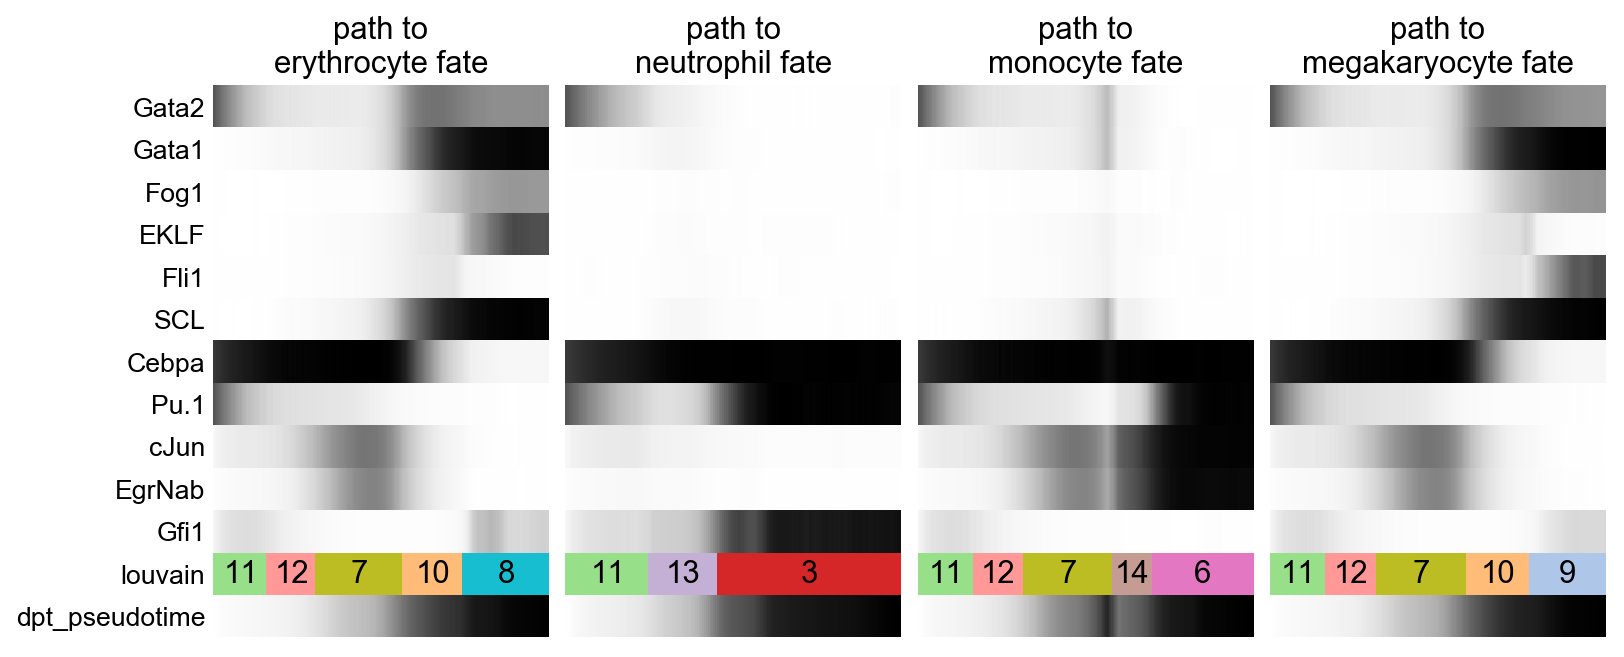

In [14]:
paths = [('erythrocytes', ['11', '12', '7', '10', '8']),
         ('neutrophils', ['11', '13', '3']),
         ('monocytes', ['11', '12', '7', '14', '6']),
         ('megakaryocytes', ['11', '12', '7', '10', '9'])]
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(
        adata, path, adata.var_names,
        left_margin=0.3, ytick_fontsize=12, color_map='Greys',
        ax=axs[ipath],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,                        
        n_avg=10,
        title='path to\n{} fate'.format(descr[:-1]),
        show=False)  # do not show the result for a single axis
pl.savefig('./figures/PAGA_path.png', dpi=300)
pl.show()

### Reclustering at higher resolution

As mentioned earlier, the resolution parameter of the Louvain clustering plays a big role. Often, you would start with a low resolution to get an overview of your dataset.

In [15]:
sc.settings.verbosity = 1
sc.tl.louvain(adata, resolution=1.5)
sc.tl.paga(adata, groups='louvain')

Let's plot the heatmap for the path to the neturophil for this resolution.

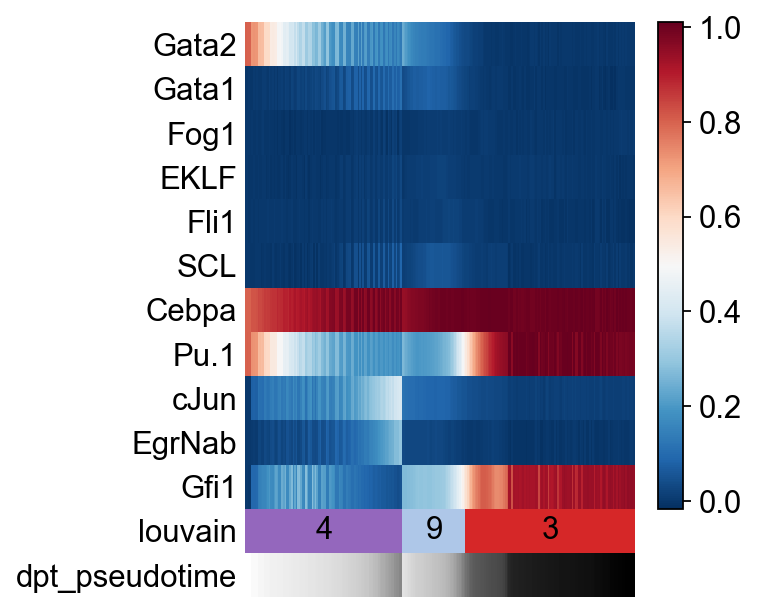

In [16]:
sc.pl.paga_path(adata, ['4', '9', '3'], adata.var_names)

Apart from changing the overall resolution to get a different coarseness, you can potentially zoom in on a particular set of clusters of interest and partition them further. To zoom into particular region, you can recluster the single-cell graph restricted to a subset. Here we want to resolve the region around the progenitor in more detail.

In [17]:
sc.tl.louvain(adata, resolution=0.8, restrict_to=('louvain', ['4']))

saving figure to file ./figures/paga_compare_coarse_R.png


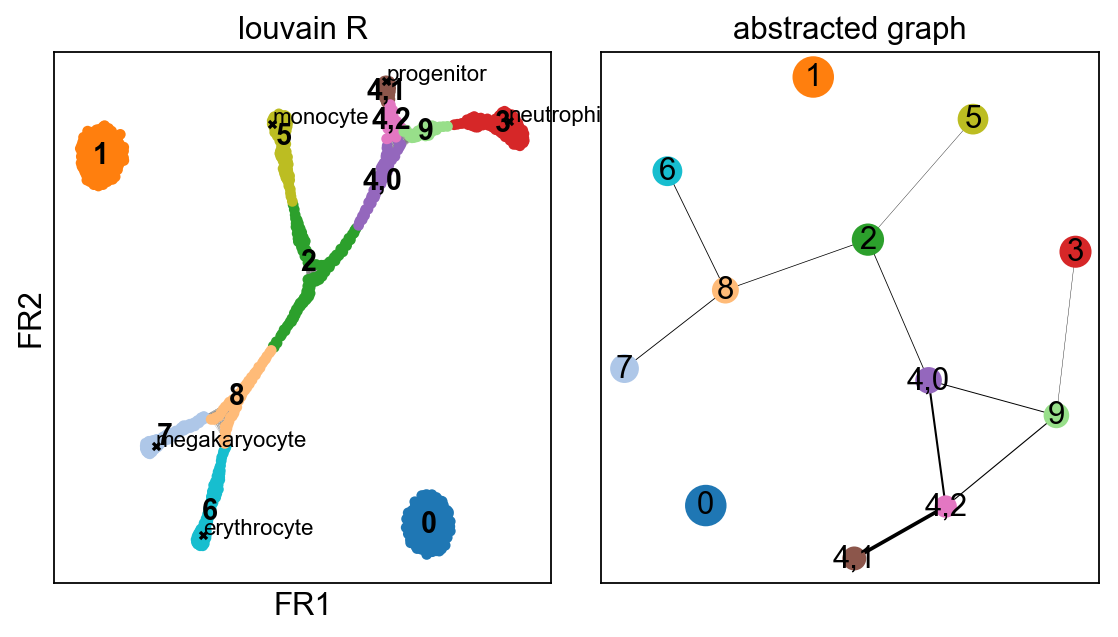

In [18]:
sc.tl.paga(adata, groups='louvain_R')
sc.pl.paga_compare(adata, basis='draw_graph_fr', save='_coarse_R')

Evidently, this more fine-grained clustering yields much smoother and more realisitic gene changes.

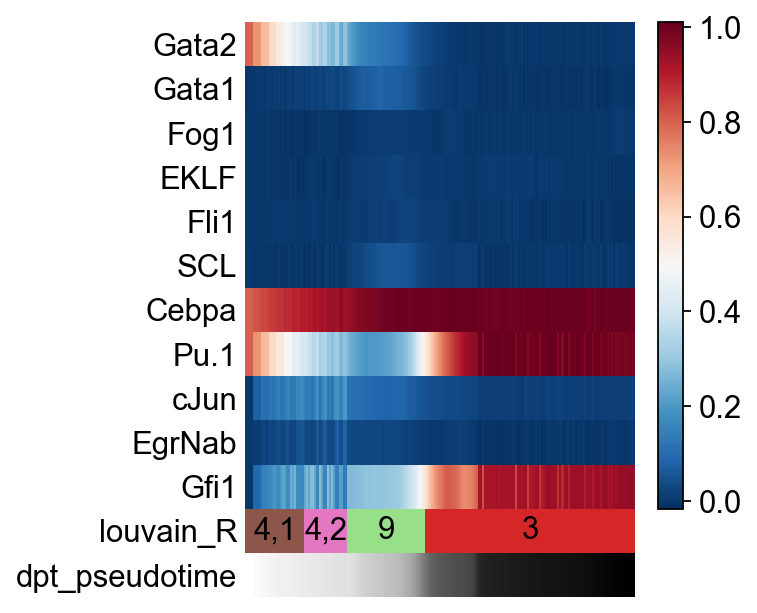

In [19]:
sc.pl.paga_path(adata, ['4,1', '4,2', '9', '3'], adata.var_names)

## Section 2: Simulated data for different degrees of clustering <a id="data2"></a>

One final example - the influence of the relative positioning of the clusters (here shown on a tSNE plot) on the resulting abstracted graph. We create five clusters using the same function that we used to generate the noise blobs in the simulated data we just analysed, but we control how isolated from each other they are by altering their standard deviations with the `cluster_std` parameter. In the case of the smallest standard deviation, the clusters are perfectly isolated from each other and PAGA sees no evidence to infer a trajectory between them. For the medium standard deviation, the clusters get to interact with each other to some degree, as evidenced by the somewhat structured tSNE and subsequently mirrored in the inferred abstracted graph. The high standard deviation leads to the clusters mixing up in a dreaded hodgepodge, the tSNE becomes difficult to decipher and the abstracted graph fills up with possible connections.

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std1.png


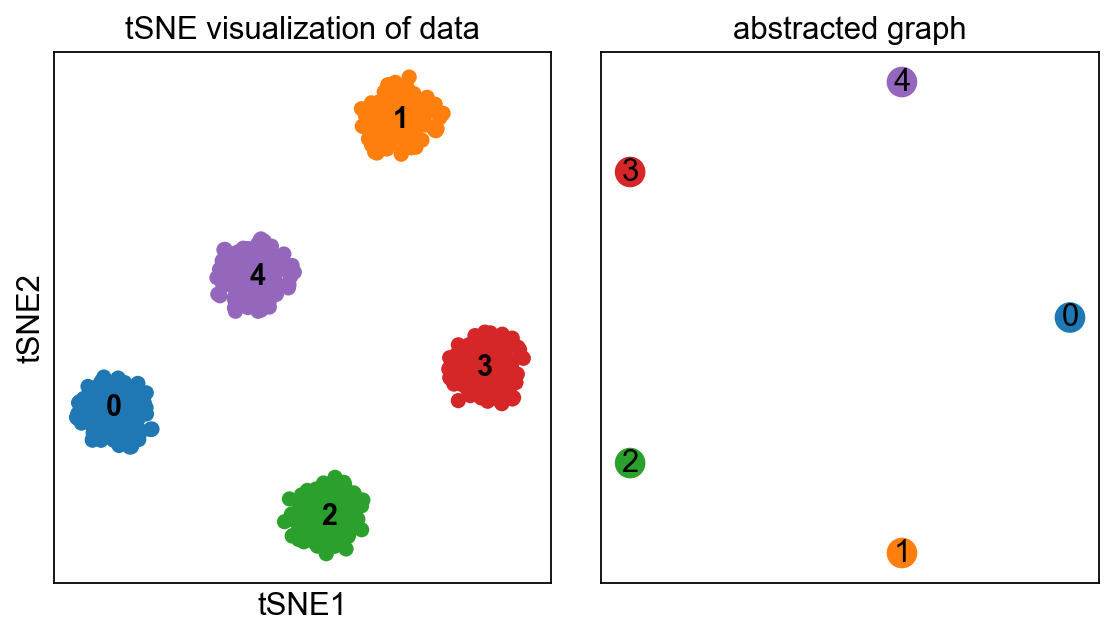

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std6.png


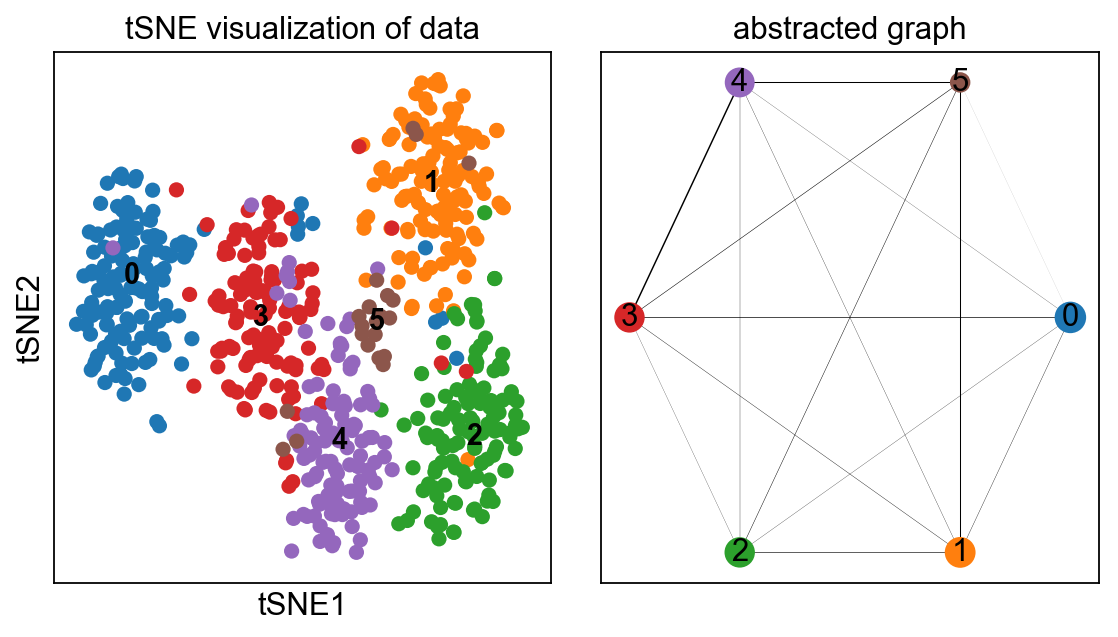

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std10.png


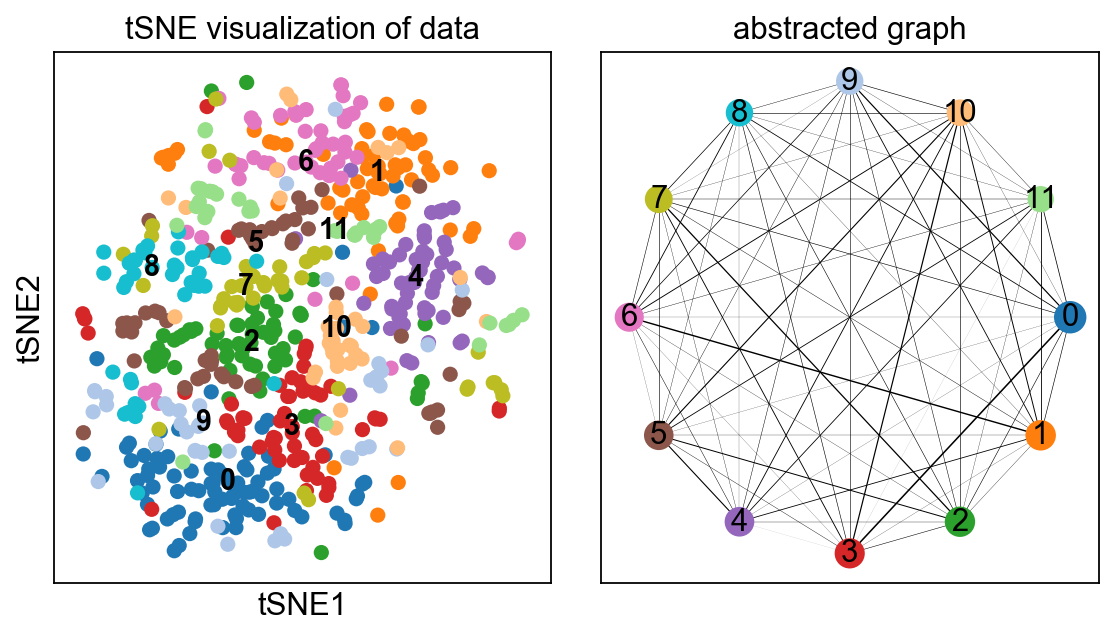

In [20]:
sc.settings.verbosity = 1
for std in [1, 6, 10]:
    adata = sc.datasets.blobs(cluster_std=std, n_centers=5)
    sc.tl.tsne(adata)
    sc.pp.neighbors(adata, n_neighbors=5)
    sc.tl.louvain(adata)
    sc.tl.paga(adata)
    sc.pl.paga_compare(
        adata,
        layout='circle',
        title='tSNE visualization of data',
        title_graph='abstracted graph',
        save='_cluster_std{}'.format(std))